# Profile line, NRMSE and SSIM

This notebook gives a brief evaluation of the output of the network. We randomly select a part of the image and draw the profile intensity of the noisy input, the clean ground truth and the result of the network. All the data ahs been normalised, the output has been scaled to the same range as the input. 

In [36]:
from dask_image.imread import imread
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_nrmse, compare_ssim, profile_line
from sklearn.metrics import mean_squared_error
from skimage.util import img_as_uint, img_as_float, img_as_float32, img_as_ubyte
from skimage import exposure
from matplotlib import patches
from skimage.morphology import disk
from skimage.filters import median, gaussian

from skimage.restoration import denoise_nl_means, estimate_sigma
from tifffile import imsave
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def read_proj(path, category):
    stack = imread(path+ category +"/*.tif")
    max_proj = np.amax(stack, axis=1)
    
    return max_proj.compute()

In [3]:
def normalize_minmse(x, target):
    """Affine rescaling of x, such that the mean squared error to target is minimal."""
    cov = np.cov(x.flatten(),target.flatten())
    alpha = cov[0,1] / (cov[0,0]+1e-10)
    beta = target.mean() - alpha*x.mean()
    return alpha*x + beta

In [4]:
def percentile_normalize(x, pmin, pmax):
    """Normalization of x using percentile min 0.1 and max 99.9"""
    mi = np.percentile(x.flatten(),pmin,axis=None,keepdims=True)
    ma = np.percentile(x.flatten(),pmax,axis=None,keepdims=True)
    percNorm = (x.flatten()-mi)/(ma-mi)
    #percNorm_noisy = (noisy.flatten()-mi)/(mi-ma)

    return percNorm

In [32]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    #image = img_as_float32(image)
    
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    
    #if (exposure.is_low_contrast(image)):
    #    image = exposure.equalize_adapthist(image)
    # Display image
    n,bins_n,patches = ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    img_cdf, bins_cdf = exposure.cumulative_distribution(image, bins_n)

    I = ax_img.imshow(image, cmap=plt.cm.magma)
    
    divider = make_axes_locatable(ax_img)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    #colorbar(I, cax=cax, orientation='vertical')
    ax_img.set_axis_off()

    # Display histogram
    #n,bins,patches = ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    #print(n)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    #ax_hist.set_xlim(0, 0.4)
    ax_hist.set_yticks([])
    
    # Display cumulative distribution
    #img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins_cdf, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [38]:
def intensity_profile(x, origin, w, h):
    profile = profile_line(x,origin,(origin[0]+w,origin[1]+h))
    return profile

In [20]:
def plot_profile():   
    fig = plt.figure(figsize=(15,15))
    for i in range(3):
        plt.subplot(1,3,i)
        plt.imshow(x[490:540,570:620])
        plt.colorbar()

In [11]:
###Enter here the path of your data (it should contain 3 folders: clean, noisy, predicted)
path = "/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/DATA/data_lattice/stack_4/GPUdecon/"

maxI_clean = read_proj(path, 'clean')
maxI_noisy = read_proj(path, 'noisy')
maxI_pred = read_proj(path, 'result')

In [12]:
maxI_pred = maxI_pred[:,:,:,0]

In [13]:
print("Noisy shape {}, Clean shape {}, Prediction shape {}".format(maxI_clean.shape,maxI_noisy.shape,maxI_pred.shape))
print("Exposure is low contrast Noisy:{}, Clean: {}, Prediction: {}".format(exposure.is_low_contrast(maxI_clean),exposure.is_low_contrast(maxI_noisy),exposure.is_low_contrast(maxI_pred)))

Noisy shape (25, 1024, 672), Clean shape (25, 1024, 672), Prediction shape (25, 1024, 672)
Exposure is low contrast Noisy:False, Clean: False, Prediction: False


In [14]:
x, y =  maxI_clean.shape[1], maxI_clean.shape[2]

In [23]:
# Percentile normalization of GT image
pmin, pmax = (0.01,99.99)
slide = 12
norm_clean = np.float32(percentile_normalize(maxI_clean[slide], pmin, pmax).reshape(x,y))
norm_noisy = np.float32(percentile_normalize(maxI_noisy[slide], pmin, pmax).reshape(x,y))

#norm_noisy = percentile_normalize(, pmin, pmax)

#Rescaling and translate prediction to match intensity range
norm_pred = normalize_minmse(maxI_pred[slide],norm_clean)

#non local mean dneoising as baseline
sigma_est = np.mean(estimate_sigma(norm_noisy, multichannel=True))
denoise = denoise_nl_means(norm_noisy, h=1.15 * sigma_est, fast_mode=False)

/home/users/allstaff/tubau.n/.conda/envs/pytorch_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/allstaff/tubau.n/.conda/envs/pytorch_env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


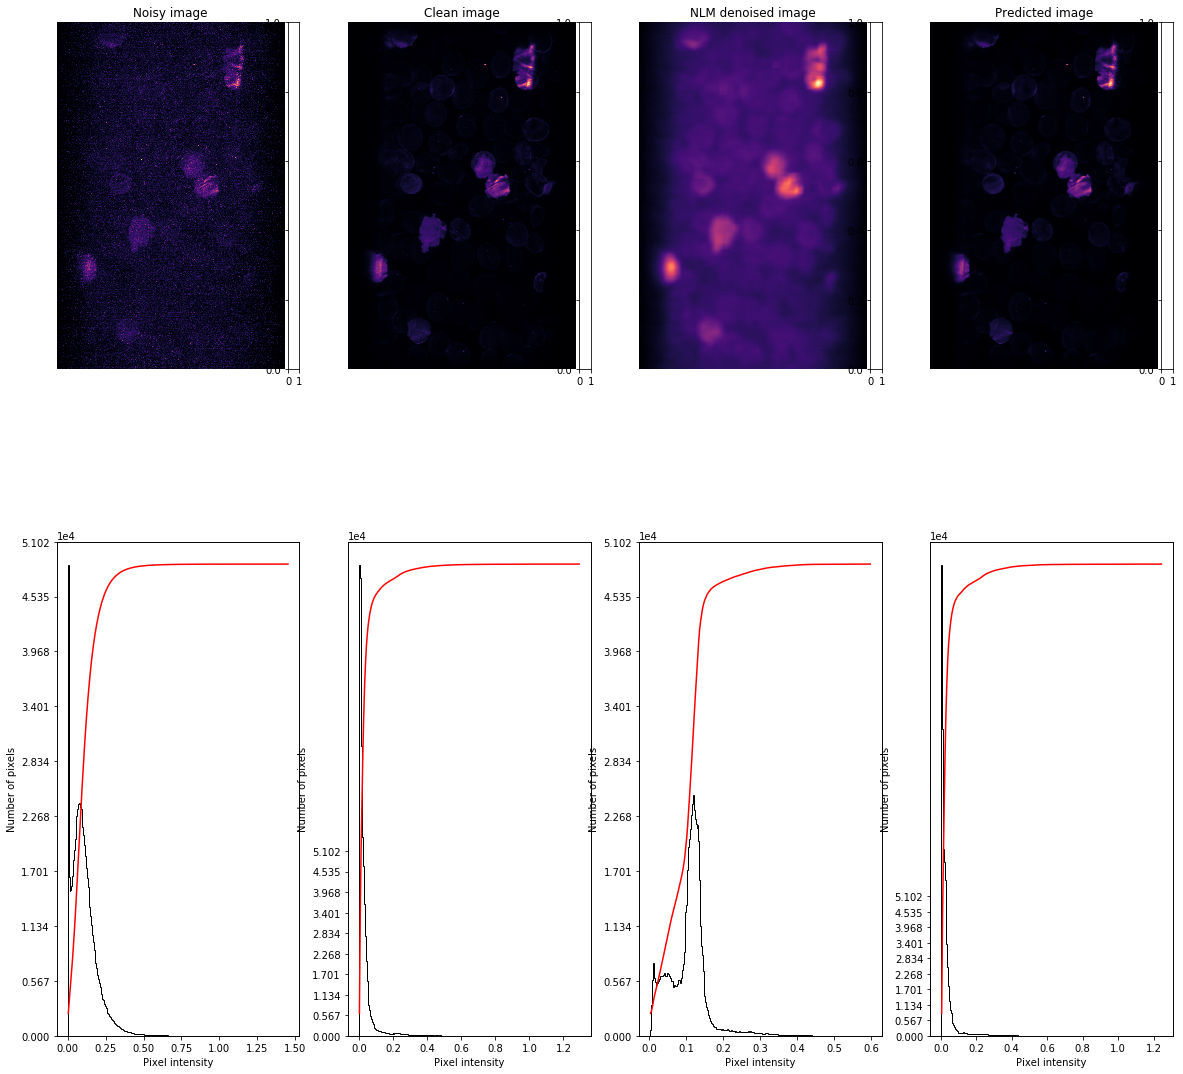

In [33]:
fig = plt.figure(figsize=(20, 20))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = plt.subplot(2, 4, 1)
axes[0, 1] = plt.subplot(2, 4, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 4, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 3] = plt.subplot(2, 4, 4, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 4, 5)
axes[1, 1] = plt.subplot(2, 4, 6)
axes[1, 2] = plt.subplot(2, 4, 7)
axes[1, 3] = plt.subplot(2, 4, 8)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(norm_noisy, axes[:, 0])
ax_img.set_title('Noisy image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 10))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(norm_clean, axes[:, 1])
ax_img.set_title('Clean image')
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 10))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(denoise, axes[:, 2])
ax_img.set_title('NLM denoised image')
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 10))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(norm_pred, axes[:, 3])
ax_img.set_title('Predicted image')
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 10))

In [29]:
color_n='#910c07'
color_c = '#83d3d4'
color_pred = '#2d8283'
color_nlm = '#999e9e'
color_smooth = '#975ad1'

Axes(0.398529,0.391471;0.227941x0.222059)
Axes(0.672059,0.391471;0.227941x0.222059)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


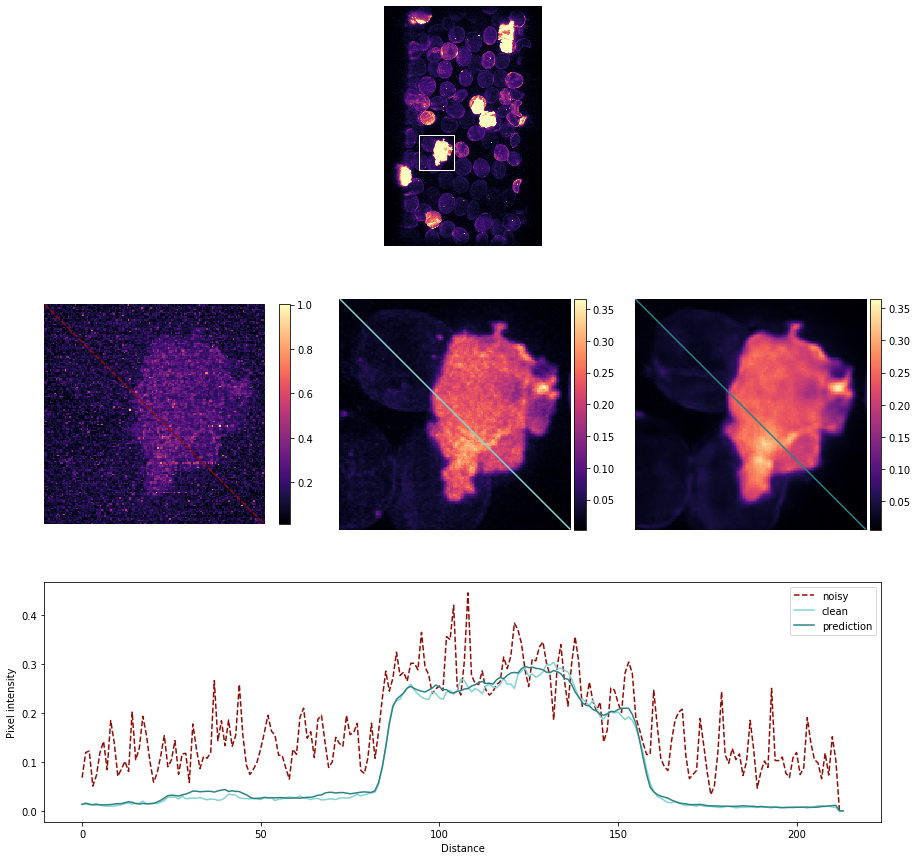

In [39]:
fig = plt.figure(figsize=(15,15))
#fig,ax = plt.subplots(1,4)

size = (150,150)
origin = (150,550)
pmin = 0.01
pmax = 99.99

ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
rect = patches.Rectangle((origin[0],origin[1]),size[0],size[1],linewidth=1,edgecolor='w',facecolor='none')
i = ax0.imshow(norm_clean.reshape(x,y), cmap=plt.cm.magma,vmin=0,vmax=0.2)
# Add the patch to the Axes
ax0.add_patch(rect)
ax0.set_axis_off()
#plt.colorbar(i)
#plt.show()

n_noisy = norm_noisy[origin[1]:origin[1]+size[1],origin[0]:origin[0]+size[0]]
n_clean = norm_clean[origin[1]:origin[1]+size[1],origin[0]:origin[0]+size[0]]
n_pred = norm_pred[origin[1]:origin[1]+size[1],origin[0]:origin[0]+size[0]]
#n_filter = percentile_normalize(img_as_float(gaussian(n_clean,sigma=1)), pmin, pmax).reshape(size[0]+1,size[1]+1)
imsave('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/noisy.tif',n_noisy)
imsave('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/clean.tif',n_clean)
imsave('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/pred.tif',n_pred)
imsave('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/full_image.tif',norm_clean)

ax1 = plt.subplot2grid((3, 3), (1, 0))
i_n = ax1.imshow(n_noisy,cmap=plt.cm.magma)
ax1.plot([0, size[0]-1], [0, size[1]-1], color=color_n,ls='--')
ax1.set_axis_off()

divider = make_axes_locatable(ax1)
#fig.colorbar(i_n, ax=ax1, extend = 'both')
cax = divider.append_axes('right', size='5%', pad=0.2)
plt.colorbar(i_n,cax=cax,orientation='vertical')
#print(cax)

ax2 = plt.subplot2grid((3, 3), (1, 1))
i_c = ax2.imshow(n_clean,cmap=plt.cm.magma)
ax2.plot([0, size[0]-1], [0, size[1]-1], color=color_c)
ax2.set_axis_off()
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(i_c,cax=cax,orientation='vertical')
print(cax)
#ax3 = plt.subplot2grid((3, 4), (1, 2))
#i_median = ax3.imshow(n_filter,cmap=plt.cm.magma)
#ax3.plot([0, size[0]-1], [0, size[1]-1], color=color_smooth)
#ax3.set_axis_off()
#divider = make_axes_locatable(ax3)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#plt.colorbar(i_median,cax=cax,orientation='vertical')

ax3 = plt.subplot2grid((3, 3), (1, 2))
i_pred = ax3.imshow(n_pred,cmap=plt.cm.magma)
ax3.plot([0, size[0]-1], [0, size[1]-1], color=color_pred)
ax3.set_axis_off()
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(i_pred,cax=cax,orientation='vertical')
print(cax)
ax4 = plt.subplot2grid((3, 4), (2, 0),colspan=4)

ax4.plot(intensity_profile(n_noisy, (0,0), size[0], size[1]),label='noisy',ls='--',color=color_n)
ax4.plot(intensity_profile(n_clean, (0,0), size[0], size[1]),label='clean',color=color_c)
ax4.plot(intensity_profile(n_pred, (0,0), size[0], size[1]),label='prediction',color=color_pred)
#ax4.plot(intensity_profile(n_filter,(0,0), size[0], size[1]),label='smooth',color=color_smooth)
ax4.legend()
plt.xlabel('Distance')
plt.ylabel('Pixel intensity')
plt.savefig('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/prof_5.eps')


In [40]:
nrmse_improvement = compare_nrmse(norm_pred,norm_clean,norm_type='min-max')
nrmse_ = compare_nrmse(norm_clean,norm_noisy,norm_type='min-max')
nrmse_nlm =  compare_nrmse(denoise,norm_clean,norm_type='min-max')

ssim_clean = compare_ssim(norm_pred,norm_clean)
ssim_noisy = compare_ssim(norm_noisy,norm_clean)
ssim_nlm = compare_ssim(denoise,norm_clean)

/home/users/allstaff/tubau.n/.conda/envs/pytorch_env/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


NRMSE: 0.07871769409593687, 0.14017344891224978 0.008419665043209654; SSIM: 0.24530587390561642, 0.4260162533135965, 0.9796049980367181 


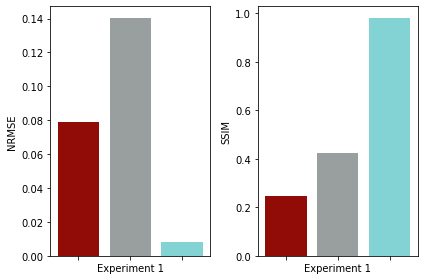

In [41]:
plt.subplot(121)

nrmse = [nrmse_,nrmse_nlm,nrmse_improvement]
ssim = [ssim_noisy,ssim_nlm,ssim_clean]
labels= ['Raw','Network']
ind=np.arange(3)
plt.bar(ind,nrmse,width=0.8, color=[color_n,color_nlm,color_c])
plt.xticks(ind, ('', 'Experiment 1', ''))
plt.ylabel('NRMSE')


plt.subplot(122)
plt.bar(ind,ssim,width=0.8, color = [color_n,color_nlm,color_c])
plt.xticks(ind, ('', 'Experiment 1', ''))
plt.ylabel('SSIM')

#plt.xticks(np.arange(2), ('Exp'))
plt.savefig('/stornext/Img/data/prkfs1/m/Microscopy/Nina_Tubau/figures/intensityProfile/NRMSE_1.eps')
plt.tight_layout()
print('NRMSE: {0}, {1} {2}; SSIM: {3}, {4}, {5} '.format(nrmse_,nrmse_nlm,nrmse_improvement,ssim_noisy,ssim_nlm,ssim_clean))